# 순서
1) 정상과정 추출
- 결정론적 추세제거
    - 회귀분석
- 확률적 추세제거
    - ADF
    - 차분

2) 정규성 확인 
- 일반선형확률과정으로 모형화하려면 정규성 검정 필요
- 불충족시 로그변환 및 Box-Cox 변환

3) ARMA 모형 차수/모수 추정
- ARMA 모형 차수 결정
    - MA: ACF cut-off
    - AR: PACF cut-off
    - ARMA: ACF, PACF cut-off 없음
        - 차수결정시 AIC/BIC 활용하여 모수추정과 동시 진행
- ARMA 모형 모수 추정
    - ADF
    - MM/LS/MLE 등 방법론

4) 모형 진단
- 잔차 가우시안 백색잡음
    - 잔차 정규성 검정
    - 잔자 ACF k=0 이외 모두 0 (Ljung-Box 검정)

# 로그변환과 Box-Cox 변환
- 비정상 확률 과정으로 모형화할 수 있는 시계열 자료에 적용
- 표준편차가 자료 크기에 비례하여 증가시 사용
    - 로그함수
    - Box-Cox

로그변환

In [7]:
%matplotlib inline
import statsmodels.api as sm
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
def convert_time(number):
    year = int(number)
    m = int(round((number-year)*12))
    delta = relativedelta(months=m)
    date = datetime(year, 1, 1) + delta
    return date    

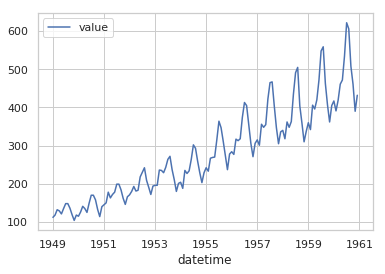

In [8]:
data = sm.datasets.get_rdataset("AirPassengers")
df = data.data
df['datetime'] = df.time.map(convert_time)
df.plot(x='datetime', y='value')
plt.show()

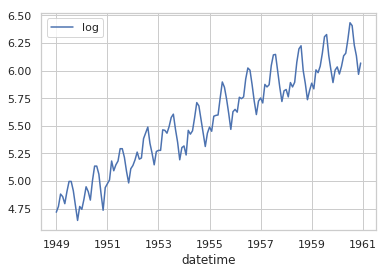

In [9]:
# 로그변환
df['log'] = np.log(df.value)
df.plot(x='datetime', y='log')
plt.show()

In [15]:
# 추세제거
# 차분 1, 2차로 나눔
sm.tsa.adfuller(df.log)[1], sm.tsa.adfuller(np.diff(df.log))[1], sm.tsa.adfuller(np.diff(np.diff(df.log)))[1]

(0.4223667747703876, 0.07112054815085905, 7.41930454937699e-13)

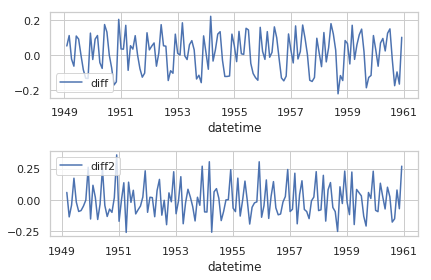

In [14]:
df['diff'] = df['log'].diff()
df['diff2'] = df['diff'].diff()
ax1 = plt.subplot(211); df.plot(x='datetime', y='diff', ax=ax1)
ax2 = plt.subplot(212); df.plot(x='datetime', y='diff2', ax=ax2)
plt.tight_layout()
plt.show()

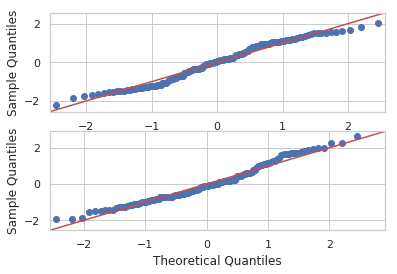

In [42]:
# QQ plot
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
sm.qqplot(df['diff'].iloc[1:], fit=True, line='45', ax=ax1)
sm.qqplot(df['diff2'].iloc[2:], fit=True, line='45', ax=ax2)
plt.show()

In [43]:
# 정규성 검정: 만족
sm.stats.stattools.omni_normtest(df['diff'].iloc[1:]),\
sm.stats.stattools.omni_normtest(df['diff2'].iloc[2:])

(NormaltestResult(statistic=28.35550839528766, pvalue=6.96112746492874e-07),
 NormaltestResult(statistic=6.6378755389588875, pvalue=0.036191254798792684))

Box-Cox 변환

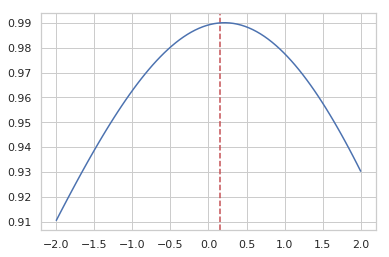

optimal lambda: 0.14802256545004658


In [55]:
# 증가추세
x, y = sp.stats.boxcox_normplot(df['value'], -2, 2)
y2, l = sp.stats.boxcox(df['value'])
df['boxcox'] = y2
plt.axvline(x=l, color='r', ls='--')
plt.plot(x, y)
plt.show()
print('optimal lambda:', l)

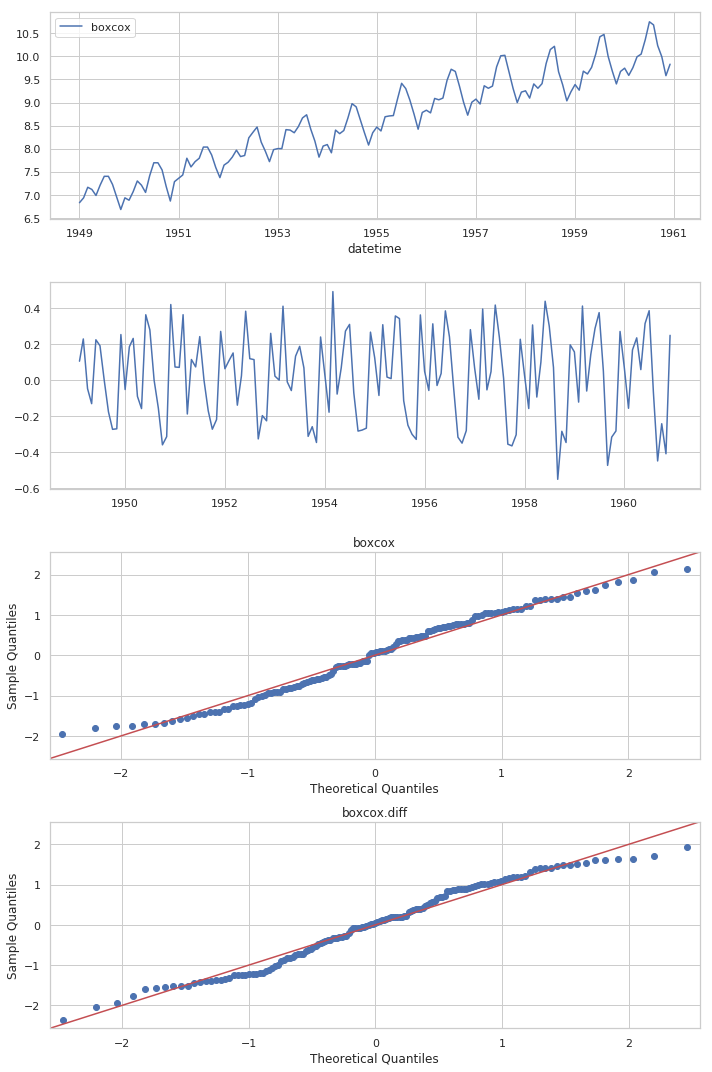

NormaltestResult(statistic=19.738952803676472, pvalue=5.172980715664152e-05)
NormaltestResult(statistic=20.438266547888265, pvalue=3.64658893040925e-05)


In [73]:
## 정규성 검정
plt.figure(figsize=(10, 15))

ax1 = plt.subplot(411)
df.plot(x='datetime', y='boxcox', ax=ax1)

plt.subplot(412)
plt.plot(df['datetime'], df['boxcox'].diff())

ax3 = plt.subplot(413)
sm.qqplot(df['boxcox'], fit=True, line='45', ax=ax3)
ax3.set_title('boxcox')

ax4 = plt.subplot(414)
sm.qqplot(df['boxcox'].diff().iloc[1:], fit=True, line='45', ax=ax4)
ax4.set_title('boxcox.diff')

plt.tight_layout()
plt.show()

print(sm.stats.stattools.omni_normtest(df['boxcox']),\
     sm.stats.stattools.omni_normtest(df['boxcox'].diff().iloc[1:]),\
     sep='\n')

# 샘플 자기상관계수 함수
- 자기상관계수 함수 정확한 값은, 해당 정상확률과정의 수학 모형 필요
- 확률과정샘플만 존재하면, 샘플 자기상관계수 함수를 구하여, 이론적 ACF 형태 유추해야
- 샘플 자기상관계수는 샘플에 의존하므로 확률변수
    - 샘플 시계열 길이 n 크면,
        - 자기상관계수의 분포가 정규분포와 비슷해짐
        - 샘플 자기상관계수의 기댓값은 이론적 자기상관계수
        - 샘플 자기상관계수의 분산은 n에 반비례
- 확률과정이 백색 잡음이면, 샘플 자기상관계수는 정규분포
$$
Var[r_k] \sim \mathcal{N}\left( \rho_k, \dfrac{1}{n} \right)
$$

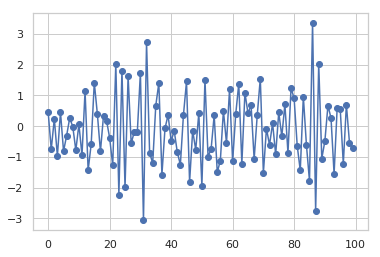

In [77]:
p = sm.tsa.ArmaProcess([1], [1, -0.7, 0.5])
y = p.generate_sample(100)
plt.plot(y, '-o')
plt.show()

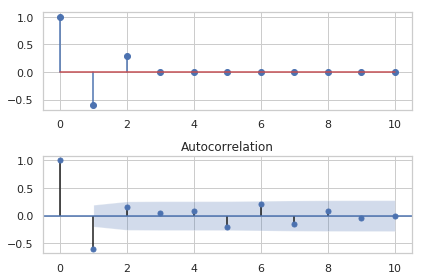

In [91]:
plt.subplot(211)
plt.stem(p.acf(lags=11))
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(y, lags=10, ax=ax)
plt.tight_layout()
plt.show()

신뢰구간

In [95]:
# confint: acf의 significance level에 대한 신뢰구간
acf, confint = sm.tsa.acf(y, alpha=0.05)

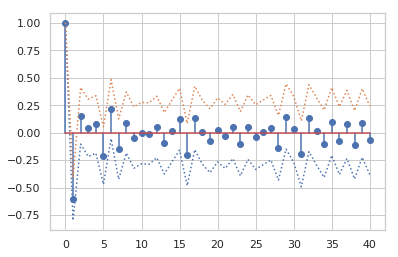

In [109]:
plt.stem(acf)
plt.plot(confint[:, 0], ":")
plt.plot(confint[:, 1], ":")
plt.show()

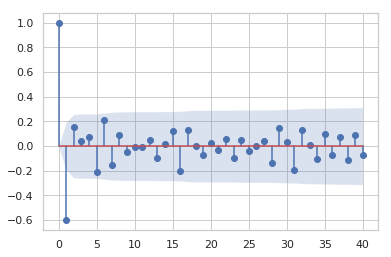

In [111]:
plt.stem(acf)
c = 0.5 * (confint[:, 1] - confint[:, 0])
plt.fill_between(np.arange(len(acf)), -c, c, alpha=0.2)
plt.show()

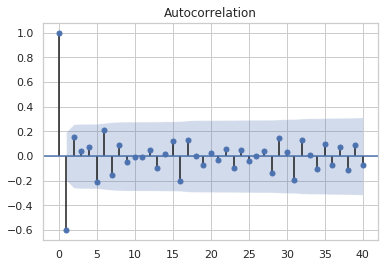

In [116]:
sm.graphics.tsa.plot_acf(y, lags=40)
plt.show()

# 편자기상관계수

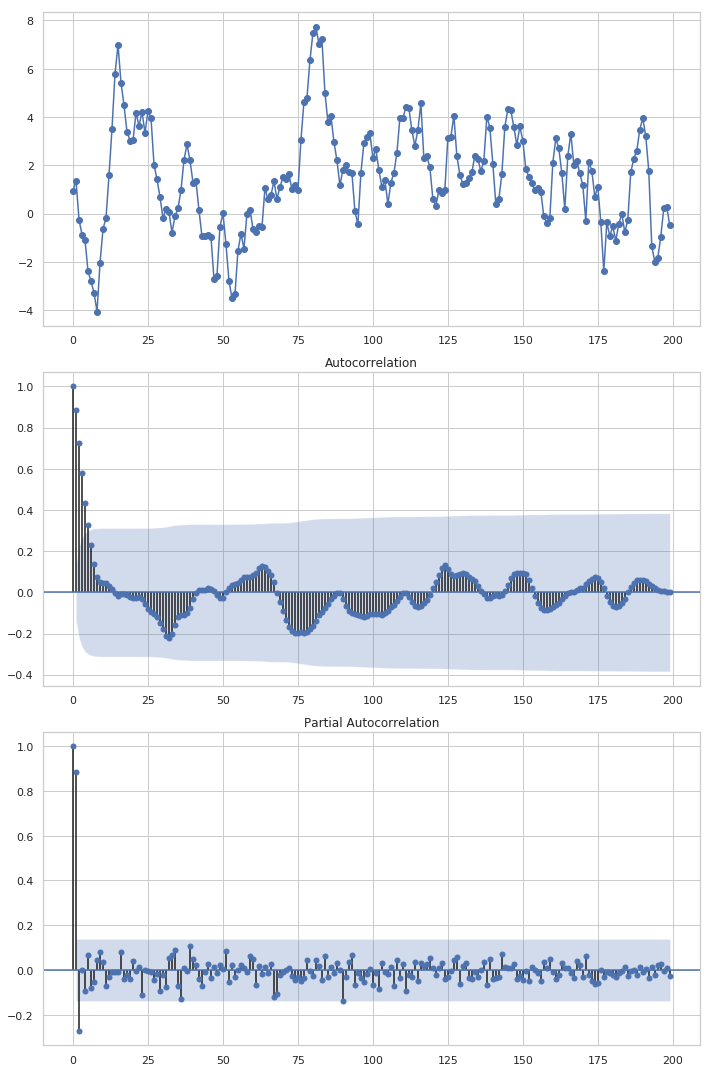

In [127]:
# AR vs MA 구분방법
p = sm.tsa.ArmaProcess([1, -1.2, 0.3], [1])
y = p.generate_sample(200)

plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(y, 'o-')
ax = plt.subplot(312)
sm.graphics.tsa.plot_acf(y, ax=ax)
ax1 = plt.subplot(313)
sm.graphics.tsa.plot_pacf(y, ax=ax1, method='ywm')

plt.tight_layout()
plt.show()